<a href="https://colab.research.google.com/github/vkthakur90/AI_Applications/blob/master/Monte_Carlo_Candlestick_Chart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade mplfinance
!pip install --upgrade pandas_ta
!pip install --upgrade yfinance

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas_ta as ta
import yfinance as yf

In [3]:
mu = 0.05
sigma = 0.02
S0 = 100
days = 250

In [4]:
def generate_price(mu, sigma, S0, days):
    price_df = pd.DataFrame({
        'n' : np.arange(24 * 60 * days),
        'W' : np.cumsum(np.random.normal(size = 24 * 60 * days))
    })

    delta_t = 1.0/(365.0 * 24 * 60)
    mu_eff = mu - 0.5 * sigma ** 2

    price_df.eval('S = @S0 * exp(@mu_eff * (n * @delta_t) + @sigma * sqrt(@delta_t) * W)', inplace = True)
    price_df.eval('V = -log(S)', inplace = True)

    candle_arr = price_df['S'].values.reshape([-1, 24 * 60])
    volume_arr = (price_df['V'] - price_df['V'].min()).values.reshape([-1, 24 * 60])

    vol_noise = np.random.normal(size=days)
    open = candle_arr[:, 0]
    high = np.max(candle_arr, axis = 1, keepdims = False)
    low = np.min(candle_arr, axis = 1, keepdims = False)
    close = candle_arr[:, -1]
    volume = np.floor(100 + np.sum(volume_arr, axis = 1, keepdims = False) + 0.5)


    candlestick_df = pd.DataFrame({
        'Open' : open,
        'High' : high,
        'Low' : low,
        'Close' : close,
        'Volume' : volume
    }, index = pd.date_range(start="2023-01-01", periods = days))

    return candlestick_df

In [5]:
def keltner_channel_plot(candlestick_df):
     indicator_df  = pd.concat([
         candlestick_df,
         candlestick_df.ta.kc(high = 'High', low = 'Low', close = 'Close', length = 20)
     ], axis = 1)

     plots = [
         mpf.make_addplot(indicator_df['KCUe_20_2'], color='blue', linestyle = '--', label = 'Keltner Channel', width = 4),
         mpf.make_addplot(indicator_df['KCLe_20_2'], color='blue', linestyle = '--', width = 4),
         mpf.make_addplot(indicator_df['KCBe_20_2'], color='blue', linestyle = '-', width = 4)
     ]

     return plots

In [6]:
def vwap_plot(candlestick_df):
     indicator_df  = pd.DataFrame({
         'High' : candlestick_df['High'],
         'Low' : candlestick_df['Low'],
         'Close' : candlestick_df['Close'],
         'Volume' : candlestick_df['Volume']
     })

     indicator_df.eval('Price = (High + Low + Close)/3', inplace = True)
     indicator_df.eval('Price_x_Volume = Price * Volume', inplace = True)
     indicator_df['cum_Price_x_Volume'] =  np.cumsum(indicator_df['Price_x_Volume'])
     indicator_df['cum_Volume'] =  np.cumsum(indicator_df['Volume'])
     indicator_df.eval('VWAP = cum_Price_x_Volume / cum_Volume', inplace = True)

     plots = [
         mpf.make_addplot(indicator_df["VWAP"], color="black", label = 'VWAP', width = 4)
     ]

     return plots

In [7]:
def triple_ema_plot(candlestick_df):
     indicator_df  = pd.concat([
         candlestick_df,
         candlestick_df.ta.ema(close = "Close", length=20),
         candlestick_df.ta.ema(close = "Close", length=50),
         candlestick_df.ta.ema(close = "Close", length=200)
     ], axis = 1)

     plots = [
         mpf.make_addplot(indicator_df["EMA_20"], color="green", label = 'EMA 20', width = 4),
         mpf.make_addplot(indicator_df["EMA_50"], color="blue", label = 'EMA 50', width = 4),
         mpf.make_addplot(indicator_df["EMA_200"], color="red", label = 'EMA 200', width = 4)
     ]

     return plots

In [8]:
def supertrend_plot(candlestick_df):
     indicator_df  = pd.concat([
         candlestick_df,
         candlestick_df.ta.supertrend(high = "High", low = "Low", close = "Close", length=10, multiplier=3)
     ], axis = 1)

     plots = [
         mpf.make_addplot(indicator_df["SUPERTl_10_3.0"], color="green", width = 4, label = 'Supertrend Long'),
         mpf.make_addplot(indicator_df["SUPERTs_10_3.0"], color="red", width = 4, label = 'Supertrend Short'),
     ]

     return plots

In [9]:
def adx_plot(candlestick_df, panel, dmi = False):
    indicator_df  = pd.concat([
         candlestick_df,
         candlestick_df.ta.adx(high='High', low='Low', close='Close', length=14)
    ], axis = 1)

    plots = [
        mpf.make_addplot(indicator_df['ADX_14'], panel=panel, color='orange', ylabel='ADX', label = 'ADX', width = 4),
    ]

    dmi_plots = [
        mpf.make_addplot(indicator_df['DMP_14'], panel=panel, color='green', label='+DI', width = 4),
        mpf.make_addplot(indicator_df['DMN_14'], panel=panel, color='red', label='-DI', width = 4)
    ]

    if dmi:
        return plots + dmi_plots
    else:
        return plots

In [10]:
def macd_plot(candlestick_df, panel):
    indicator_df  = pd.concat([
         candlestick_df,
         candlestick_df.ta.macd(close="Close", fast=12, slow=26, signal=9)
    ], axis = 1)

    plots = [
        mpf.make_addplot(indicator_df["MACD_12_26_9"], panel=panel, color="blue", ylabel="MACD", label = 'MACD', width = 4),
        mpf.make_addplot(indicator_df["MACDs_12_26_9"], panel=panel, color="orange", label = 'Signal', width = 4),
        mpf.make_addplot(
            indicator_df["MACDh_12_26_9"],
            type="bar",
            panel=panel,
            color=["green" if val >= 0 else "red" for val in indicator_df["MACDh_12_26_9"]],
            alpha=0.5,
            ylabel = 'Histogram'
        ),
    ]


    return plots

In [11]:
def rsi_plot(candlestick_df, panel):
    indicator_df  = pd.concat([
         candlestick_df,
         candlestick_df.ta.rsi(close="Close", length=14)
    ], axis = 1)

    plots = [
         mpf.make_addplot(indicator_df["RSI_14"], panel = panel, color="purple", ylabel="RSI", label = 'RSI', width = 4),
    ]

    return plots

In [12]:
def obv_plot(candlestick_df, panel):
    indicator_df  = pd.concat([
         candlestick_df,
         candlestick_df.ta.obv(close="Close", volume="Volume")
    ], axis = 1)

    plots = [
         mpf.make_addplot(indicator_df['OBV'], panel = panel, color='blue', label='OBV', width = 4, ylabel = 'OBV')
    ]

    return plots

In [13]:
def plot_candle_sticks(mu, sigma, S0, days):
    candlestick_df = generate_price(mu, sigma, S0, days)

    plots = (
        vwap_plot(candlestick_df) +
        supertrend_plot(candlestick_df) +
        keltner_channel_plot(candlestick_df) +
        obv_plot(candlestick_df, panel = 1) +
        macd_plot(candlestick_df, panel = 2) +
        rsi_plot(candlestick_df, panel = 3) +
        adx_plot(candlestick_df, panel = 3)
    )

    rc =  {
        'font.size': 40,             # General font size
        'axes.labelsize': 40,        # Axis labels
        'xtick.labelsize': 40,       # X-axis tick labels
        'ytick.labelsize': 40,       # Y-axis tick labels
        'axes.titlesize': 40,         # Title size
        'axes.edgecolor' : 'black',
        'axes.linewidth' : 2
    }

    style = mpf.make_mpf_style(
        base_mpf_style='yahoo',
        rc = rc
    )

    mpf.plot(
        candlestick_df,
        type="candle",  # Candlestick chart
        style=style,  # Chart style
        addplot=plots,
        figscale = 8,
        volume = True,
        panel_ratios=(3, 1, 1, 1),
    )

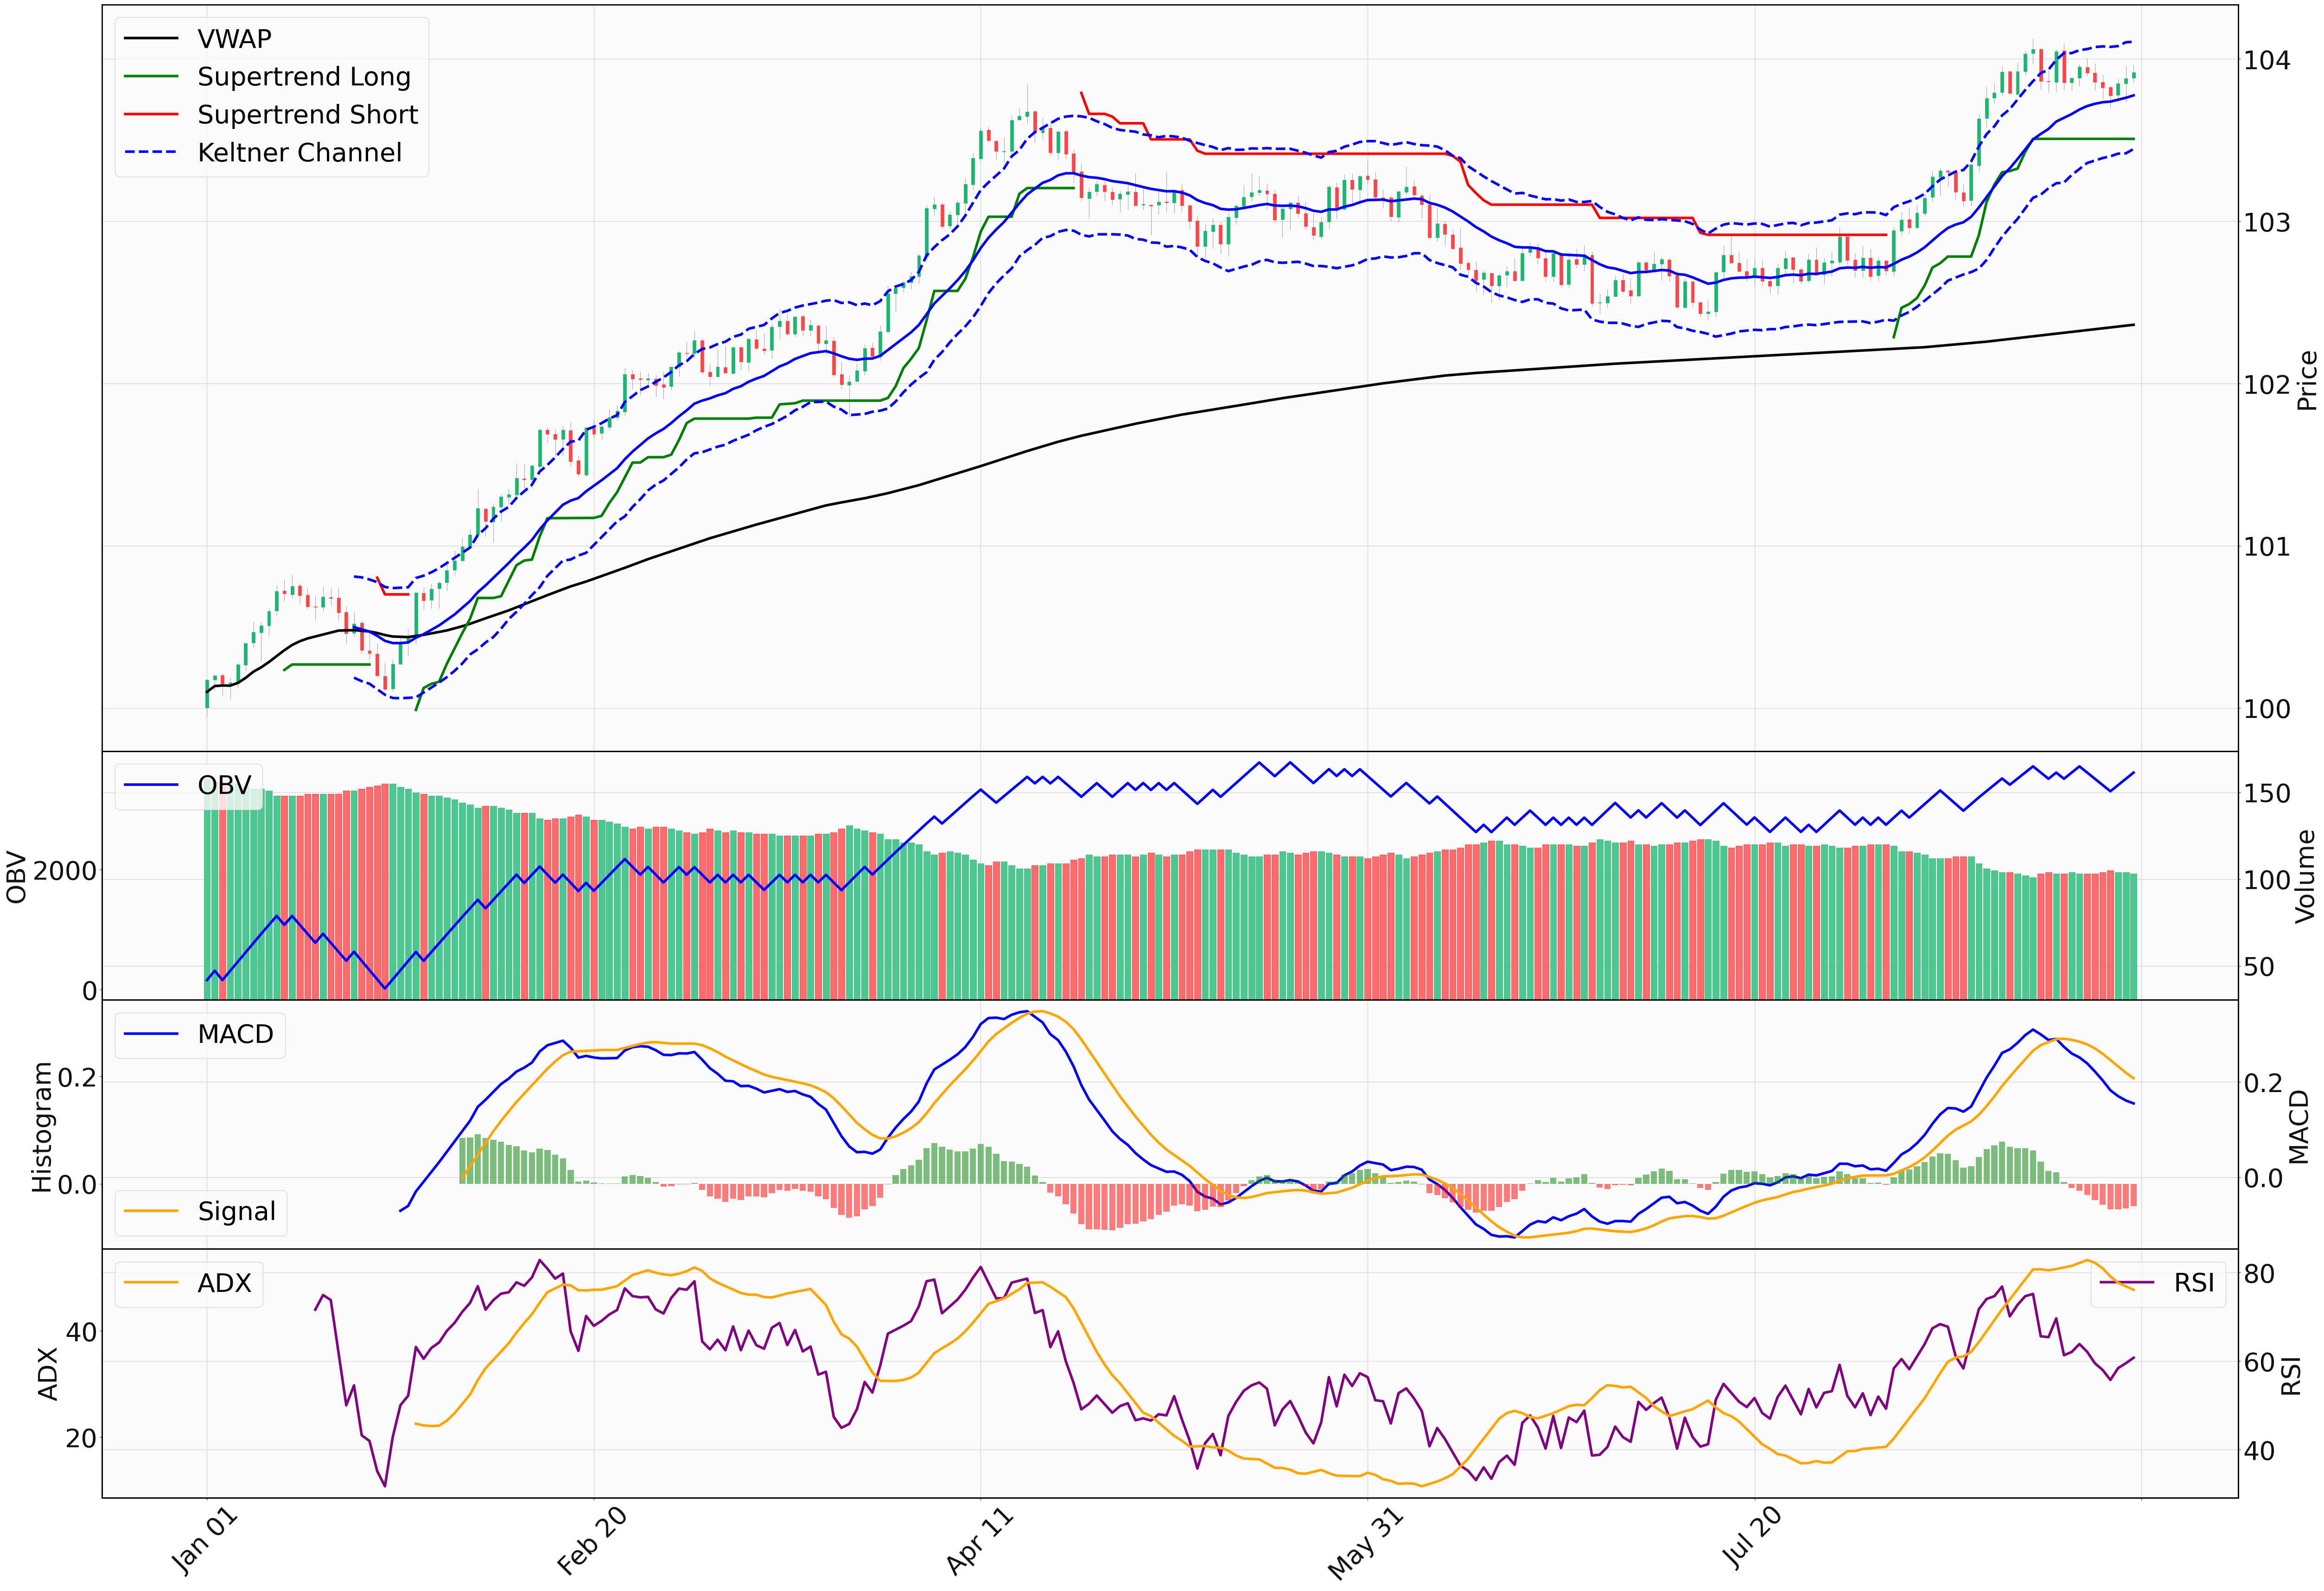

In [14]:
plot_candle_sticks(mu, sigma, S0, days)